### We will see in this notebook how to de-noise data using an autoencoder
##### Run this on colab GPU

In [4]:
from keras.datasets import mnist
import numpy as np

(x_train,_),(x_test,_) = mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


In [0]:
# normalise the data
x_train = x_train.astype('float32')/255.0
x_test = x_test.astype('float32')/255.0

# reshape the data
# we need 3D because we're going to do convolution
x_train = x_train.reshape((-1,28,28,1))
x_test = x_test.reshape((-1,28,28,1))

In [0]:
noise_factor = 0.5
x_train_noisy = x_train + noise_factor*np.random.normal(loc=0.0,scale=1.0,size=(60000,28,28,1))
x_test_noisy = x_test + noise_factor*np.random.normal(loc=0.0,scale=1.0,size=(10000,28,28,1))
x_train_noisy = np.clip(x_train_noisy,0.0,1.0)
x_test_noisy = np.clip(x_test_noisy,0.0,1.0)

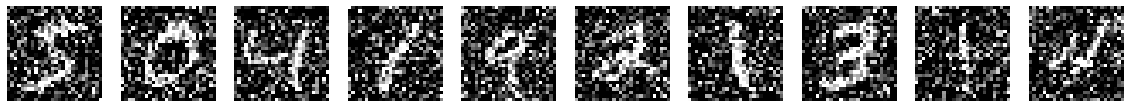

In [7]:
import matplotlib.pyplot as plt
n = 10
plt.figure(figsize=(20,4))
for i in range(n):
  ax = plt.subplot(1,n,i+1)
  plt.imshow(x_train_noisy[i].reshape(28,28),cmap='gray')
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

In [8]:
from keras import layers,models

input_img = layers.Input(shape=(28,28,1))
x = layers.Conv2D(32,(3,3),activation='relu',padding='same')(input_img) # padding fills the space where the convolution window doesn't reach the edges of our image
x = layers.MaxPooling2D((2,2),padding='same')(x)
x = layers.Conv2D(32,(3,3),activation='relu',padding='same')(x)
encoded = layers.MaxPooling2D((2,2),padding='same')(x)

x = layers.Conv2D(32,(3,3),activation='relu',padding='same')(encoded)
x = layers.UpSampling2D((2,2))(x) # this layer is the opposite to maxpooling. it adds more detail
x = layers.Conv2D(32,(3,3),activation='relu',padding='same')(x)
x = layers.UpSampling2D((2,2))(x)
decoded = layers.Conv2D(1,(3,3),activation='sigmoid',padding='same')(x)

autoencoder = models.Model(input_img,decoded)
autoencoder.compile(
  optimizer='adadelta',
  loss = 'binary_crossentropy'
)
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 14, 14, 32)        9248      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 7, 7, 32)          9248      
_________________________________________________________________
up_sampling2d_3 (UpSampling2 (None, 14, 14, 32)        0         
__________

In [9]:
# we can now fit our noisy data against our clean data, and create a de-noising autoencoder
autoencoder.fit(
    x_train_noisy,x_train,
    epochs = 100,
    batch_size = 128,
    shuffle = True,
    validation_data = (x_test_noisy,x_test)
)

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 12s 208us/step - loss: 0.1774 - val_loss: 0.1240
Epoch 2/100
60000/60000 [==============================] - 8s 139us/step - loss: 0.1189 - val_loss: 0.1104
Epoch 3/100
60000/60000 [==============================] - 8s 135us/step - loss: 0.1113 - val_loss: 0.1102
Epoch 4/100
60000/60000 [==============================] - 8s 135us/step - loss: 0.1079 - val_loss: 0.1039
Epoch 5/100
60000/60000 [==============================] - 8s 136us/step - loss: 0.1057 - val_loss: 0.1052
Epoch 6/100
60000/60000 [==============================] - 8s 139us/step - loss: 0.1042 - val_loss: 0.1025
Epoch 7/100
60000/60000 [==============================] - 8s 135us/step - loss: 0.1031 - val_loss: 0.1017
Epoch 8/100
60000/60000 [==============================] - 8s 136us/step - loss: 0.1024 - val_loss: 0.1001
Epoch 9/100
60000/60000 [==============================] - 8s 135us/step - loss: 0.1016 - val

In [15]:
# pass the noisy images and get clean images
de_noised_test = autoencoder.predict(x_test_noisy)
print(de_noised_test.shape)

(10000, 28, 28, 1)


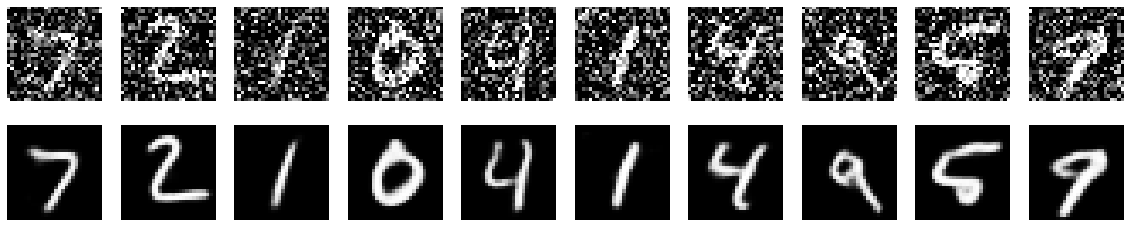

In [16]:
n = 10

plt.figure(figsize=(20,4))

for i in range(n):
    ax = plt.subplot(2,n,i+1)
    plt.imshow(x_test_noisy[i].reshape((28,28)),cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    ax = plt.subplot(2,n,i+1+n)
    plt.imshow(de_noised_test[i].reshape((28,28)),cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
plt.show()
plt.close()